# Explaining Text Classifiers with Counterfactual Representations 

Dataset: BiasInBios with 'gender' as the manipulated concept (2 concept values)

In [90]:
from concept_erasure import LeaceEraser, LeaceFitter
import torch
import numpy as np
import scipy

from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.neural_network import MLPClassifier,  MLPRegressor
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


from matplotlib import pyplot
from matplotlib.ticker import FormatStrFormatter


In [91]:
# Global parameters

projection_method = 'orth' # 'orth' or 'leace' ('leace' is the oblique projection from Belrose et al., 2023, LEACE: Perfect linear concept erasure in closed form, NeurIPS 2023)
global_seed = 42 # used for reproductibility
rcond = 1e-5 # used for regressions 

dataset = 'glove-gender'
dataset = 'original' 

lin_cl_loss = 'log_loss'
concept_manipulated = 'gender' # 'gender' 

## LOADING DATA 

- Data is located in the dataset: *./datasets/EEEC/EEEC_3race/*
- **bert** representations for each observations have been pre-calculated using **bert-base-uncased** model (via Huggingface library) and stored in a dictonnary of arrays *D.npz*

## Loading train, validation and test data

In [92]:
def load_glove(max_samples = None, normalize=True): 
    import pickle
    data_folder = './datasets/glove-gender/'
    # dataset = 'glove-gender'
    # concept_to_erase = 'gender'

    filename = f'glove-gender-data.pickle'

    # Load the original train, validation, test split
    with open(data_folder + filename, "rb") as f:
        data_dict = pickle.load(f)
        X,Z,words_train = data_dict["train"]
        X_val, Z_val,words_val = data_dict["dev"]
        X_test, Z_test, words_test = data_dict["test"]
        
        X,Z = X[Z > -1], Z[Z>-1]
        X_val,Z_val = X_val[Z_val > -1], Z_val[Z_val>-1]
        X_test, Z_test = X_test[Z_test > -1], Z_test[Z_test>-1]
        
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        X_val = np.concatenate([X_val, np.ones((X_val.shape[0], 1))], axis=1)
        X_test = np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=1)
        
        if normalize:
            X/=np.linalg.norm(X,axis=1,keepdims=True)
            X_val/=np.linalg.norm(X_val,axis=1,keepdims=True)
            X_test/=np.linalg.norm(X_test, axis=1, keepdims=True)
            
    
    if max_samples is not None and type(max_samples) is int:
        N_samples = min(max_samples, X.shape[0])
        idx = np.arange(X.shape[0])
        # np.random.shuffle(idx, seed))
        X, Z = X[idx[:N_samples]], Z[idx[:N_samples]]
        
    return X, None, Z, X_val, None, Z_val, X_test, None, Z_test, None, None, words_train, words_val, words_test


X, _, Z_raw, X_val, _, Z_val_raw, X_test, _, Z_test_raw, _, _, words_train, words_val, words_test = load_glove(normalize=True)



n, d = X.shape # n: number of observations in the train set, d: number of features
n_test, _ = X_test.shape # n_test: number of observations in the test set
n_validation, _ = X_val.shape # n_validation: number of observations in the validation set
z_values = sorted(np.unique(Z_raw)) # list of concept values
k = len(z_values) # number of concept values


z_label2id = {z_values[i]:i for i in range(len(z_values))}

Z = np.array([z_label2id[z] for z in Z_raw]).astype(int)
Z_test = np.array([z_label2id[z] for z in Z_test_raw]).astype(int)
Z_val = np.array([z_label2id[z] for z in Z_val_raw]).astype(int)


# Calculate the one hot version of Z
def to_one_hot(A):
        A_1hot = np.zeros((A.size, A.max()+1))
        A_1hot[np.arange(A.size), A] = 1
        return A_1hot
Z_1hot = to_one_hot(Z)

# calculate number of observations per value of Z and Y
z_label2numobs_train = {z_values[i]:np.nonzero([Z==z_label2id[z_values[i]]])[0].shape[0] for i in range(len(z_values))}
z_label2numobs_validation = {z_values[i]:np.nonzero([Z_val==z_label2id[z_values[i]]])[0].shape[0] for i in range(len(z_values))}
z_label2numobs_test = {z_values[i]:np.nonzero([Z_test==z_label2id[z_values[i]]])[0].shape[0] for i in range(len(z_values))}

z_id2label = {int(v):k for k,v in z_label2id.items()}


# Display dataset statistics:
print(f''' 
Features:
    d = {d}
Number of observations:
    train: {n}
    validation: {n_validation}
    test: {n_test}
Z labels (protected concept levels): 
    k = {k} 
    mapping: {z_label2id.__str__()}
    num_obs_train: {z_label2numobs_train.__str__()}
    num_obs_validation: {z_label2numobs_validation.__str__()}
    num_obs_test: {z_label2numobs_test.__str__()}
''')

 
Features:
    d = 301
Number of observations:
    train: 7350
    validation: 3150
    test: 4500
Z labels (protected concept levels): 
    k = 2 
    mapping: {0: 0, 1: 1}
    num_obs_train: {0: 3632, 1: 3718}
    num_obs_validation: {0: 1592, 1: 1558}
    num_obs_test: {0: 2276, 1: 2224}



# Training linear classifiers

$\hat{Y}$: mood state classifier (POMS)

$\hat{Z}$: race classifier (3 values)

Training a POMS linear classifier

In [93]:
def linear_classifier(args, random_state=global_seed):
    lcf = SGDClassifier(
        loss=lin_cl_loss, validation_fraction=0.2, early_stopping=True, random_state=random_state, 
        penalty='l2', max_iter=5000, n_jobs=-1, learning_rate='optimal', warm_start=True, n_iter_no_change=200
    )
    lcf.set_params(**args)
    return lcf

### Training of $\widehat{Z}$

In [94]:
## Uncomment if you want to make a grid search
#
# eta_z = linear_classifier({'alpha': 1e-5})
# parameters = {
#     'alpha':[1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
# }
# eta_z = GridSearchCV(eta_y, parameters)

In [95]:
eta_z = linear_classifier({'alpha': 1e-5})
eta_z.fit(X, Z)
print("Train accuracy:", f"{100*eta_z.score(X, Z):.2f}%")
print("Test accuracy: ", f"{100*eta_z.score(X_test, Z_test):.2f}%") 

Train accuracy: 100.00%
Test accuracy:  100.00%


In [96]:
print("Per value accuracy:\n")
z_predicted = eta_z.predict(X)
z_predicted_test = eta_z.predict(X_test)
print("label id", f"{'label name':<25}", "train acc. (%)", "test acc. (%)")
for i in range(k):
    acc_i = np.sum(z_predicted[Z == i] == i) / np.sum([Z == i])
    acc_i_test = np.sum(z_predicted_test[Z_test == i] == i) / np.sum([Z_test == i])
    print(f"{i:<8}",f"{z_id2label[i]:<25}", f"{100*acc_i:<14.2f}", f"{100*acc_i_test:<13.2f}")

Per value accuracy:

label id label name                train acc. (%) test acc. (%)
0        0                         100.00         100.00       
1        1                         100.00         100.00       


## Concept Erasure

Concept to erase: gender (2 values)\
Erasure method: orthogonal projection on $V^\perp$ (by default) or LEACE oblique projection on $V^\perp$ 

### Erasure

In [97]:
class Erasure:
    
    def __init__(self, projection='orth', rcond=1e-5):
        """
        Parameters: 
        projection (str): 'orth' for an orthogonal projection, 'leace' for an oblique projection using the LEACE projector
        rcond (str): linalg rcond coef
        """
        self.rcond = rcond
        self.projection = projection
        self.P = None
        self.SigXZ = None
        self.E_SigXZ = None
        self.E_P = None
    
    def fit(self, X, Z_1hot):
        self.SigXZ = LeaceFitter.fit(
            torch.Tensor(X),
            torch.Tensor(Z_1hot)
        ).sigma_xz.numpy()
        self.E_SigXZ = scipy.linalg.orth(self.SigXZ, rcond=self.rcond).T

        if self.projection == 'leace':
            self.P = LeaceEraser.fit(
                torch.Tensor(X),
                torch.Tensor(Z_1hot)                    
        ).P.numpy()
        else:
            # I - A (A.T A)^-1 A.T
            self.P = np.eye(self.SigXZ.shape[0]) - self.E_SigXZ.T @ np.linalg.inv(self.E_SigXZ @ self.E_SigXZ.T) @ self.E_SigXZ
        self.E_P = scipy.linalg.orth(self.P, rcond=self.rcond).T
    
    def erase_concept(self, X):
        return X @ self.P.T
    
    def to_vec(self, coordinates, subspace):
        E_subspace = self.E_P if subspace == 'E_P' else self.E_SigXZ
        if len(coordinates.shape) < 2:
            return coordinates[:,np.newaxis] @ E_subspace
        else:
            return coordinates @ E_subspace
    
    def get_coordinates(self, X, subspace):
        E_subspace = self.E_P if subspace == 'E_P' else self.E_SigXZ
        if self.projection == 'leace':
            return (X - X @ self.P.T) @ E_subspace.T.squeeze()
        else:
            return X @ E_subspace.T.squeeze()


In [98]:
LinearErasure = Erasure(projection=projection_method, rcond=rcond)
LinearErasure.fit(X, Z_1hot)
print("Rank of colsp(Sigma_XZ):", LinearErasure.E_SigXZ.shape[0], f"\t(sanity check: must be equal to k-1 = {k-1})")
print("Rank of colsp(P):       ", LinearErasure.E_P.shape[0], f"\t(sanity check: must be equal to d-k+1 = {d-k+1})")

Rank of colsp(Sigma_XZ): 1 	(sanity check: must be equal to k-1 = 1)
Rank of colsp(P):        300 	(sanity check: must be equal to d-k+1 = 300)


### Evaluation of the linear erasure

In [99]:
X_ = LinearErasure.erase_concept(X)
X_test_ = LinearErasure.erase_concept(X_test)

# Check that predicting linearly Z from X_ leads to bad results (concept has been erased linearly)
sgdclass = linear_classifier({'alpha': 1e-4}).fit(X_, Z)
print(f"Accuracy of a linear classifier trained to predict Z from X_orth:")
print("Train accuracy:", f"{100*sgdclass.score(X_,Z):.2f}%")
print("Test accuracy: ", f"{100*sgdclass.score(X_test_, Z_test):.2f}%", f"\t(must be approx. {100/k:.2f}%)\n") 


Accuracy of a linear classifier trained to predict Z from X_orth:
Train accuracy: 50.56%
Test accuracy:  48.80% 	(must be approx. 50.00%)



In [100]:
# Check if a non-linear classifier can predict accurately Z from X_
mlpclf = MLPClassifier(random_state=global_seed, max_iter=300, early_stopping=True).fit(X_, Z)
print(f"Accuracy of a non-linear classifier (2-layer MLP) trained to predict Z from X_orth:")
print("Train accuracy:", f"{100*mlpclf.score(X_,Z):.2f}%")
print("Test accuracy: ", f"{100*mlpclf.score(X_test_, Z_test):.2f}%", f"\t(>> {100/k:.2f}%))")

Accuracy of a non-linear classifier (2-layer MLP) trained to predict Z from X_orth:
Train accuracy: 99.40%
Test accuracy:  97.04% 	(>> 50.00%))


# Plot the data

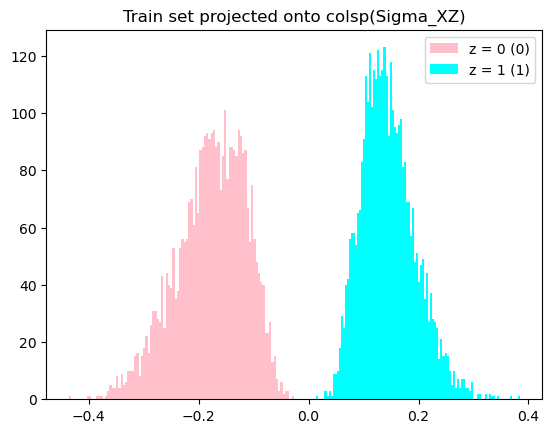

In [101]:
# Plot

# need to add the case where v[0] == 0
def vect_to_equation(v, x, intercept_x = 0):
    y = v[1] / v[0] * (x - intercept_x) 
    return y

lambda_SigXZ = LinearErasure.get_coordinates(X, subspace='E_SigXZ')
mean_lambda = np.mean(lambda_SigXZ)

colors = ['pink', 'cyan']

# Plot the training data points 
for z in np.unique(Z):
    indices = Z == z
    X_SigXZ_z = lambda_SigXZ[indices]
    _ = pyplot.hist(X_SigXZ_z, bins=100, label=f'z = {z} ({z_id2label[z]})', color=colors[z])

_ = pyplot.title('Train set projected onto colsp(Sigma_XZ)')
_ = pyplot.legend()


# Linear reconstruction of $x^\parallel$ with a MSE loss objective

In [102]:
# To improve
# - don't use LEACE library to calculate Sigma_XZ and the LEACE projector

class LinearConceptValueAssignmentWithMSEloss:

    def __init__(self, random_state=global_seed, rcond=rcond):
        self.predictors = {}
        self.noises = {}
        self.LinearErasure = Erasure() # P and Sigma_XZ in it
        self.random_state = random_state
        self.alpha = 5e-2 #orth
        # self.alpha = 1e-4 #leace
        self.lr = 1e-3

    def fit_linear_regression(self, X, Z, linreg_args = {}, validate=False, X_validation=None, Z_validation=None):
        shuffle = True
        validation_fraction = 0.3
        if validate:
            validation_fraction = X_validation.shape[0] / (X.shape[0] + X_validation.shape[0]) 
            X = np.concatenate((X,X_validation), axis=0)
            Z = np.concatenate((Z,Z_validation))
            shuffle = False
        
        X_ = self.LinearErasure.erase_concept(X)
        coord_SigXZ = self.LinearErasure.get_coordinates(X, subspace='E_SigXZ')
        for z in np.unique(Z): 
            linear_regression_mse = MLPRegressor(
                hidden_layer_sizes=(), # linear
                activation="identity",
                max_iter=5000,
                solver='adam',
                early_stopping=True,
                validation_fraction=validation_fraction,
                n_iter_no_change=100,
                alpha=self.alpha,
                learning_rate_init=self.lr,
                random_state=self.random_state,
                warm_start=True,
                shuffle=shuffle
            )
            linear_regression_mse.set_params(**linreg_args)
            linear_regression_mse.fit(X_[Z==z], coord_SigXZ[Z==z])
            self.predictors[z] = linear_regression_mse
        return True

    def fit_gaussian_dispersion(self, X, Z):
        X_ = self.LinearErasure.erase_concept(X)
        coord_SigXZ = self.LinearErasure.get_coordinates(X, subspace='E_SigXZ')
        # Calculate the noise variance per concept value
        for z in np.unique(Z):
            nu_X = self.predictors[z].predict(X_[Z==z])
            noise = coord_SigXZ[Z==z] - nu_X
            if noise.ndim == 1:
                noise = noise.reshape(-1, 1)
            gmm = GaussianMixture(n_components=1, covariance_type='full', max_iter=300)
            gmm.fit(noise)
            self.noises[z] = gmm
        return True

    def fit(self, X, Z, validate=False, X_validation=None, Z_validation=None):
        self.fit_linear_regression(X, Z, validate=validate, X_validation=X_validation, Z_validation=Z_validation)
        self.fit_gaussian_dispersion(X, Z)
        return True
    
    def predict_nu(self, X, Z_assigned):
        X_ = self.LinearErasure.erase_concept(X)
        coord_SigXZ_predicted = np.empty((X.shape[0], self.LinearErasure.E_SigXZ.shape[0]))
        for z in np.unique(Z_assigned):
            indices = Z_assigned == z
            predictions = self.predictors[z].predict(X_[indices])
            if len(predictions.shape) < 2: # predictions must be a matrix with 2 dimensions
                predictions = predictions[:,np.newaxis]
            coord_SigXZ_predicted[indices] = predictions
        X_SigXZ  = self.LinearErasure.to_vec(coord_SigXZ_predicted, subspace='E_SigXZ') 
        return X_ + X_SigXZ


    def predict(self, X, Z_assigned, no_sampling = False):
        X_n_nu = self.predict_nu(X, Z_assigned)
        # Let's sample noise for each observation
        if not no_sampling:
            X_noises_sampled = np.empty(X.shape)
            for z in np.unique(Z_assigned):
                indices = Z_assigned == z
                n_noises = np.sum(indices)
                noises = self.noises[z].sample(n_noises)
                X_noises_sampled[indices] = self.LinearErasure.to_vec(noises[0],subspace='E_SigXZ')
            return X_n_nu + X_noises_sampled
        else:
            return X_n_nu
        
    def score(self, X, Z):
        X_nu = self.predict(X, Z, no_sampling=True) 
        return np.mean(np.linalg.norm(X-X_nu, axis=1))

    def sample_counterfactuals(self, X, z_value, no_sampling=False):
        color = 'blue'
        Z_assigned = np.full((X.shape[0],), z_value)
        X_to_plot = self.predict(X, Z_assigned, no_sampling)
        X_to_plot = self.LinearErasure.get_coordinates(X_to_plot, subspace='E_SigXZ')
        if len(X_to_plot.shape) > 1 and X_to_plot.shape[1] == 2:
            _ = pyplot.scatter(X_to_plot[:,0], X_to_plot[:,1], s=0.1, color=color)
        elif len(X_to_plot.shape) == 1:
            _ = pyplot.hist(X_to_plot[:,], bins=100, color=color)  
    


In [103]:
LCVA_mse = LinearConceptValueAssignmentWithMSEloss(random_state=global_seed)
LCVA_mse.LinearErasure = LinearErasure
LCVA_mse.fit(X,Z, validate=True, X_validation=X_val, Z_validation=Z_val)

True

In [104]:
print("MSE (train):     ", f"{LCVA_mse.score(X, Z):.4f}")
print("MSE (validation):", f"{LCVA_mse.score(X_val, Z_val):.4f}")
print("MSE (test):      ", f"{LCVA_mse.score(X_test, Z_test):.4f}")


MSE (train):      0.0236
MSE (validation): 0.0234
MSE (test):       0.0248


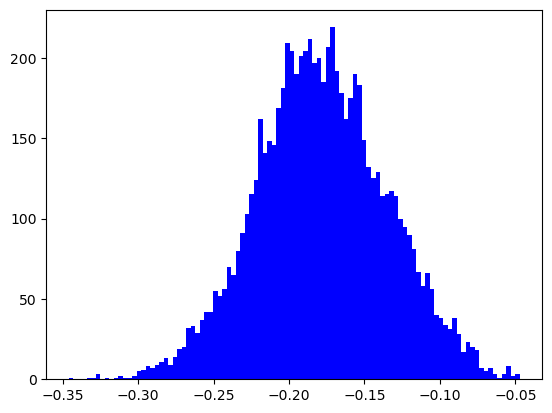

In [105]:
# Sample countefractuals and display them in V^{\parallel}
LCVA_mse.sample_counterfactuals(X, z_value=0, no_sampling=True)

## Evaluations

### Proximity of CFRs

In [106]:
def load_glove_top50k(): 
    import pickle
    data_folder = './datasets/glove-gender/'
    # dataset = 'glove-gender'
    # concept_to_erase = 'gender'

    filename = f'glove-top-50k.pickle'

    # Load the full data
    with open(data_folder + filename, "rb") as f:
        data_dict = pickle.load(f)
        print(data_dict.keys())
        # return None
        
        X = data_dict["vecs"]
        X = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
        words = data_dict["words"]
        
    return X, words

X50k, words50k = load_glove_top50k()
words50k = np.array(words50k)
print(X50k.shape)
print(words50k.shape)

dict_keys(['words', 'vecs'])
(150000, 301)
(150000,)


In [107]:
import random
for w in words_test[:10]:
    print(w)

theologians
-471
thigh-high
anglers
watford
field
robina
kelley
jeanine
army


In [198]:
# Find the ids of some gender biased words
words_complete = np.concatenate([words_train, words_val, words_test])
X_complete = np.concatenate([X, X_val, X_test])
Z_complete = np.concatenate([Z, Z_val, Z_test])
X_CFR_complete = LCVA_mse.predict(X_complete, 1 - Z_complete, no_sampling=True)

def find_closest(x_orig, x, X):
    mse = np.sqrt(np.linalg.norm(X - x, axis=1)**2)
    mse_orig = np.sqrt(np.linalg.norm(X - x_orig, axis=1)**2)
    indices_min = np.argsort(mse)[:100]
    indices_min = indices_min[mse[indices_min] < mse_orig[indices_min]]
    return indices_min[:5]


biased_words = ["he", "man", "king", "heir", "henry", "jürgen", "napoleon", "federer", "apostle", "sceptre", "cufflinks", "priests", "demigods", "medvedev", "homosexual", "cowboys", "charlemagne", "lucifer", "spokesman", "garcon"]
print("Original words are male-biased", f"({len(biased_words)})")
indices_biased = np.in1d(words_complete, biased_words)
ordered_words = words_complete[indices_biased]
ordered_indices = np.argwhere(indices_biased)
X_ordered_words = X_complete[indices_biased]
X_CFRs_ordered_words = X_CFR_complete[indices_biased]
for i in range(len(ordered_words)):
    print(ordered_words[i], '--->', words_complete[find_closest(X_ordered_words[i], X_CFRs_ordered_words[i], X_complete)])



Original words are male-biased (20)
cufflinks ---> ['earrings' 'necklace' 'necklaces' 'brooches' 'bracelet']
spokesman ---> ['spokeswoman' 'chairwoman' 'publicist' 'susan' 'lisa']
priests ---> ['priestesses' 'priestess' 'sisters' 'daughters' 'mothers']
cowboys ---> ['cowgirls' 'cheerleaders' 'cheerleader' 'girls' 'ladies']
lucifer ---> ['lilith' 'aphrodite' 'goddess' 'angelic' 'cordelia']
apostle ---> ['magdalene' 'mary' 'pauline' 'catherine' 'sister']
homosexual ---> ['lesbian' 'sexuality' 'transgender' 'sex' 'lesbians']
garcon ---> ['fille' 'joli' 'meagan' 'lexie' 'petite']
federer ---> ['sharapova' 'azarenka' 'clijsters' 'wozniacki' 'serena']
jürgen ---> ['birgit' 'ulrike' 'renate' 'susanne' 'kerstin']
heir ---> ['heiress' 'daughter' 'granddaughter' 'niece' 'daughters']
he ---> ['she' 'her' 'girl' 'herself' 'woman']
king ---> ['queen' 'princess' 'elizabeth' 'daughter' 'sister']
demigods ---> ['goddesses' 'princesses' 'goddess' 'godess' 'vamps']
sceptre ---> ['tiara' 'cassiopeia' 'at

In [288]:
biased_words = ["she", "woman", "cowgirls", "dress", "shirley", "gertrude", "cleopatra", "galadriel", "feminist", "maids", "hairstyle", "girlish", "fille", "bridesmaid", "chairwoman", "mini-skirt", "wifes", "madonna", "sorceress", "daughters"]
print("Original words are female-biased", f"({len(biased_words)})")
indices_biased = np.in1d(words_complete, biased_words)
ordered_words = words_complete[indices_biased]
ordered_indices = np.argwhere(indices_biased)
X_ordered_words = X_complete[indices_biased]
X_CFRs_ordered_words = X_CFR_complete[indices_biased]
for i in range(len(ordered_words)):
    print(ordered_words[i], '--->', words_complete[find_closest(X_ordered_words[i] ,X_CFRs_ordered_words[i], X_complete)])

Original words are female-biased (20)
cleopatra ---> ['caesar' 'julius' 'pharaoh' 'emperor' 'augustus']
galadriel ---> ['gandalf' 'sauron' 'saruman' 'boromir' 'faramir']
hairstyle ---> ['goatee' 'sideburns' 'clean-cut' 'should' 'he']
woman ---> ['man' 'he' 'guy' 'who' 'him']
sorceress ---> ['barbarian' 'sword' 'swordsman' 'cleric' 'warlord']
gertrude ---> ['ernest' 'henry' 'albert' 'charles' 'harold']
fille ---> ['fils' 'compte' 'père' 'garcon' 'par']
maids ---> ['laborers' 'servant' 'plumbers' 'employed' 'employ']
cowgirls ---> ['cowboys' 'broncos' 'mavericks' 'devils' 'mavs']
madonna ---> ['jesus' 'judas' 'pope' 'saints' 'holy']
dress ---> ['jersey' 'should' 'cap' 'game' 'he']
she ---> ['he' 'him' 'his' 'who' 'himself']
wifes ---> ['guys' 'guy' 'dependable' 'man' 'decent']
girlish ---> ['effeminate' 'clean-cut' 'virile' 'affable' 'pugnacious']
mini-skirt ---> ['jockstrap' 'hardhat' 'fullback' 'goatee' 'pinstripe']
feminist ---> ['marxist' 'political' 'philosophical' 'socialist' 'disc